In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import network_generation as homomul
import spread_simulation
import homophily_multi_attr_viz as viz
from tqdm.notebook import tqdm

# Spread based on Consolidation and Homophily

In [3]:
model_settings = {
    'N': 3200, 
    'm': 5, 
    'consolidation_param': 0.1,
    'marginal_distribution': [[0.5,0.5],[0.5,0.5]], 
    'homophily': 0.8, 
    'complex_threshold': 0.16,
    'initial_seed_filter': lambda x: x.nodes
}

experiment_settings = {
    'n_networks': 2,
    'n_initial_seeds': 5
    }


spread_simulation.batch_simulate(**model_settings, **experiment_settings)

(0.10665625000000001, 0.1)

  0%|          | 0/66 [00:00<?, ?it/s]

consolidation_param: 0.00 / homophily: 0.00 => avg = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.10 => avg = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.20 => avg = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.30 => avg = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.40 => avg = 0.11; global = 0.10
consolidation_param: 0.00 / homophily: 0.50 => avg = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.60 => avg = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.70 => avg = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.80 => avg = 0.31; global = 0.30
consolidation_param: 0.00 / homophily: 0.90 => avg = 0.11; global = 0.10
consolidation_param: 0.00 / homophily: 1.00 => avg = 0.25; global = 0.00
consolidation_param: 0.10 / homophily: 0.00 => avg = 0.01; global = 0.00
consolidation_param: 0.10 / homophily: 0.10 => avg = 0.21; global = 0.20
consolidation_param: 0.10 / homophily: 0.20 => avg 

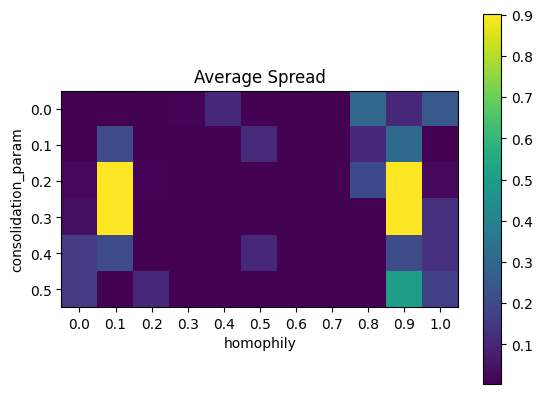

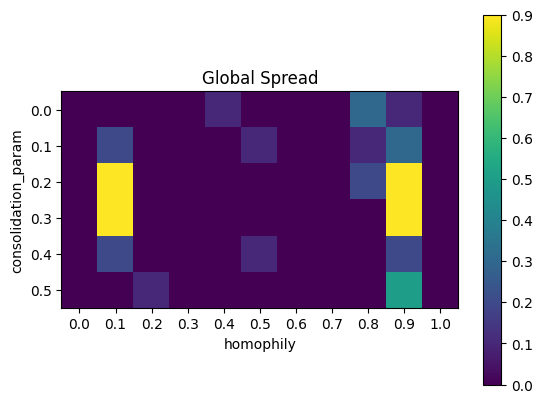

In [4]:
homophily_settings = np.linspace(0,1,11)
consolidation_settings = np.linspace(0,0.5, 6)

results_average, results_global_spread = spread_simulation.setting_simulate('consolidation_param', consolidation_settings, 
                                                          'homophily', homophily_settings, 
                                                          model_settings, experiment_settings)


## Groups ability to spread: 


  0%|          | 0/66 [00:00<?, ?it/s]

/home/fabian/Documents/_Studium/Sem10/Project/IP_Homophily/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/fabian/Documents/_Studium/Sem10/Project/IP_Homophily/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


consolidation_param: 0.00 / homophily: 0.00 => avg = nan; global = nan
consolidation_param: 0.00 / homophily: 0.10 => avg = nan; global = nan
consolidation_param: 0.00 / homophily: 0.20 => avg = nan; global = nan
consolidation_param: 0.00 / homophily: 0.30 => avg = nan; global = nan
consolidation_param: 0.00 / homophily: 0.40 => avg = nan; global = nan
consolidation_param: 0.00 / homophily: 0.50 => avg = nan; global = nan
consolidation_param: 0.00 / homophily: 0.60 => avg = nan; global = nan
consolidation_param: 0.00 / homophily: 0.70 => avg = nan; global = nan
consolidation_param: 0.00 / homophily: 0.80 => avg = nan; global = nan
consolidation_param: 0.00 / homophily: 0.90 => avg = nan; global = nan
consolidation_param: 0.00 / homophily: 1.00 => avg = nan; global = nan
consolidation_param: 0.10 / homophily: 0.00 => avg = 0.01; global = 0.00
consolidation_param: 0.10 / homophily: 0.10 => avg = 0.01; global = 0.00
consolidation_param: 0.10 / homophily: 0.20 => avg = 0.00; global = 0.00


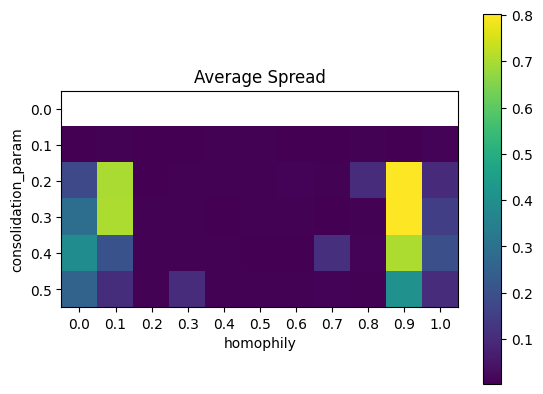

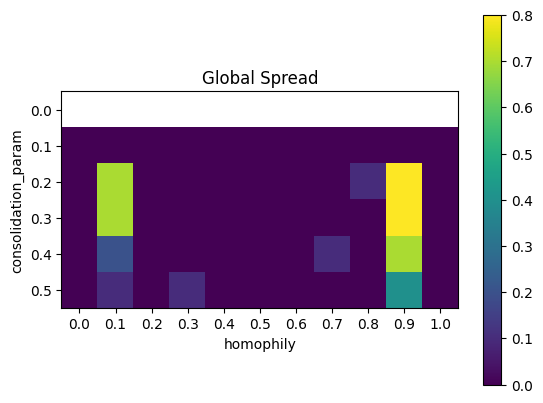

In [5]:
def filter_by_group(group): 
    def f(g: nx.Graph) -> list:
        return [x for x, attr in g.nodes('attr') if attr == group]
    
    return f
    
model_settings['initial_seed_filter'] = filter_by_group((0,0))
results_average, results_global_spread = spread_simulation.setting_simulate('consolidation_param', consolidation_settings, 
                                                          'homophily', homophily_settings, 
                                                          model_settings, experiment_settings)

  0%|          | 0/66 [00:00<?, ?it/s]

consolidation_param: 0.00 / homophily: 0.00 => avg = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.10 => avg = 0.11; global = 0.10
consolidation_param: 0.00 / homophily: 0.20 => avg = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.30 => avg = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.40 => avg = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.50 => avg = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.60 => avg = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.70 => avg = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.80 => avg = 0.21; global = 0.20
consolidation_param: 0.00 / homophily: 0.90 => avg = 0.40; global = 0.40
consolidation_param: 0.00 / homophily: 1.00 => avg = 0.15; global = 0.00
consolidation_param: 0.10 / homophily: 0.00 => avg = 0.01; global = 0.00
consolidation_param: 0.10 / homophily: 0.10 => avg = 0.11; global = 0.10
consolidation_param: 0.10 / homophily: 0.20 => avg 

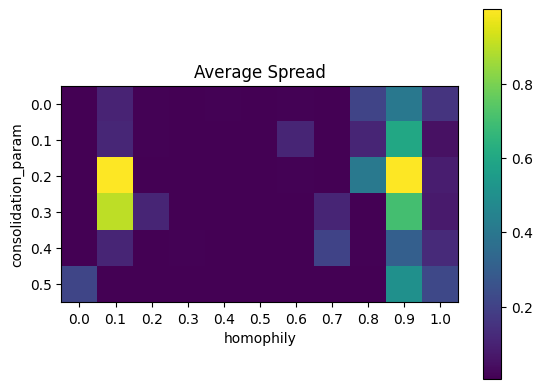

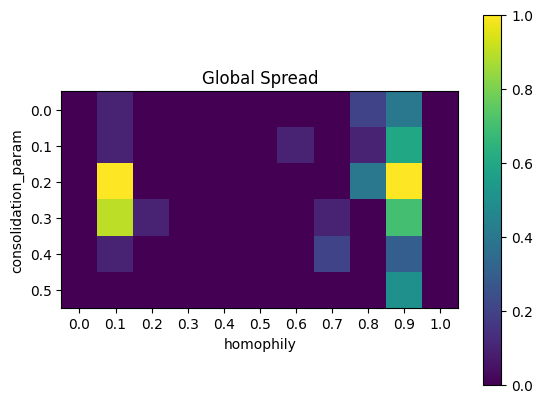

In [6]:
model_settings['initial_seed_filter'] = filter_by_group((0,1))
results_average, results_global_spread = spread_simulation.setting_simulate('consolidation_param', consolidation_settings, 
                                                          'homophily', homophily_settings, 
                                                          model_settings, experiment_settings)